# Basic lightcurve

In [1]:
import os
from glob import glob

try:
    from astropy.io import fits as pf
except:
    import pyfits as pf

import numpy as np
from datetime import datetime as dt
from photutils import DAOStarFinder
from astropy.stats import sigma_clipped_stats
import matplotlib.pyplot as plt
%matplotlib inline

#import pandas as pd

#filedir='/mnt/B838B30438B2C124/research/transit/df_HATP44/HATP44_data/'
filedir='/home/jp/data/hatp44_data/'
file_list = glob(os.path.join(filedir,'*.fits'))
file_list.sort()

len(file_list)

1457

In [2]:
from tqdm import tqdm

gband=[]
rband=[]
zband=[]

for i in tqdm(file_list):
    hdr = pf.open(i)[0].header
    #if hdr['OBJECT']  == 'HAT-P-44':
    if hdr['FILTER'] == 'g':
        gband.append(i)
    elif hdr['FILTER'] == 'r':
        rband.append(i)
    elif hdr['FILTER'] == 'z_s':
        zband.append(i)
    else: #redundancy
        print(i)
        
print('{0}\n{1}\n{2}'.format(len(gband), len(rband), len(zband)))

100%|██████████| 1457/1457 [00:05<00:00, 284.75it/s]

376
704
377


## Test image

In [3]:
test_image = pf.open(gband[0])[0].data

## Crop image

In [4]:
import numpy as np

def get_crop(image, centroid, box_size):
    x, y = centroid
    image_crop = np.copy(image[int(y-(box_size/2)):int(y+(box_size/2)),int(x-(box_size/2)):int(x+(box_size/2))])

    return image_crop

In [5]:
centroid = (700, 305)
test_image_crop = get_crop(test_image, centroid, box_size=80)

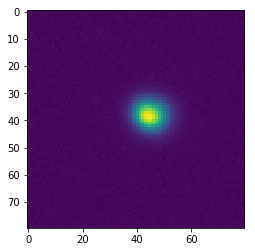

In [6]:
plt.imshow(test_image_crop)

## Compute Centroid 

In [7]:
from photutils.centroids import centroid_com as com

def get_centroid(image):
    '''
    Calculate the centroid of a 2D array as its “center of mass” determined from image moments.
    '''
    centroid = com(image)
    return centroid

In [9]:
centroid = get_centroid(test_image_crop)
centroid

array([ 39.85587354,  39.38727026])

## Do photometry

[`photutils.aperture`](http://photutils.readthedocs.io/en/latest/photutils/aperture.html)

for masking, [see](http://stackoverflow.com/questions/8647024/how-to-apply-a-disc-shaped-mask-to-a-numpy-array)

In [10]:
from photutils import CircularAperture
from photutils import aperture_photometry


def get_phot(image, centroid, r=10):
    fwhm = 8.0
    
    apertures = CircularAperture(centroid, r)
    phot_table = aperture_photometry(image, apertures)
    
    #xcenter = phot_table['xcenter']
    #ycenter = phot_table['ycenter']
    #centroid = (xcenter, ycenter)
    aperture_sum = float(phot_table['aperture_sum'])
    
    return aperture_sum #,centroid

In [11]:
aperture_sum = get_phot(test_image_crop, centroid)
aperture_sum

1693392.6533980244

## Masking

In [20]:
def cmask(image,centroid,aperture_radius):
    a,b = get_centroid(image)
    nx,ny = image.shape
    y,x = np.ogrid[-a:nx-a,-b:ny-b]
    mask = x*x + y*y <= aperture_radius**2
    
    add = sum(image[mask])
    background = np.median(image[~mask])
    
    return background

In [21]:
cmask(test_image_crop, centroid, aperture_radius=15)

2566.3691

In [12]:
centroid_init = (700, 305)
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []

for i in tqdm(gband):
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroid_init, box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)
    
    xcenters.append(centroid[0])
    ycenters.append(centroid[1])
    
    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)

100%|██████████| 376/376 [00:08<00:00, 43.73it/s]


In [13]:
import pandas as pd

#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'aperture_sum'    : aperture_sums}

df_gband = pd.DataFrame(d, index = obs_time)

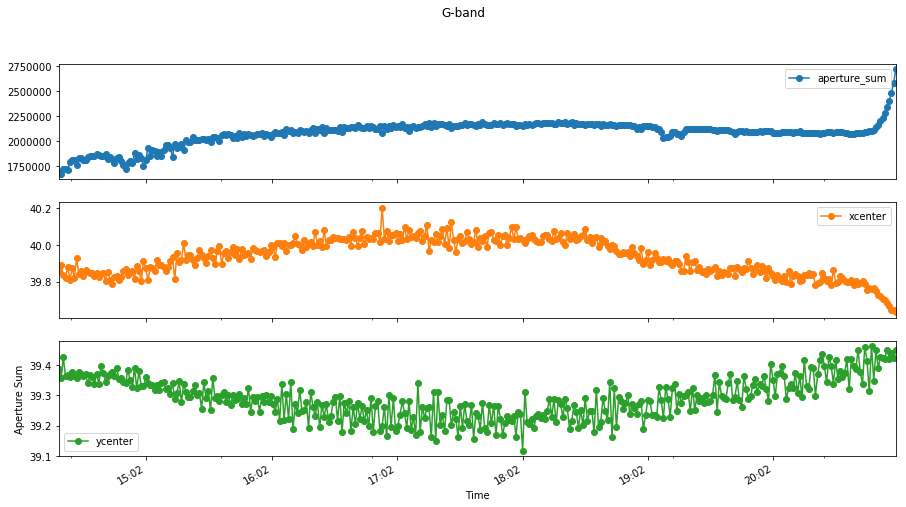

In [14]:
import matplotlib.dates as dates

axs = df_gband.plot(title='G-band', marker='o', subplots=True, figsize=(15,8))
axs.flat[2].xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
axs.flat[2].set_ylabel('Aperture Sum')
axs.flat[2].set_xlabel('Time')

In [15]:
centroid_init = (700, 305)
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []

from tqdm import tqdm

for i in tqdm(rband):
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroid_init, box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)
    
    xcenters.append(centroid[0])
    ycenters.append(centroid[1])
    
    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)
    
#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'aperture_sum'    : aperture_sums}

df_rband = pd.DataFrame(d, index = obs_time)

100%|██████████| 704/704 [00:16<00:00, 42.03it/s]


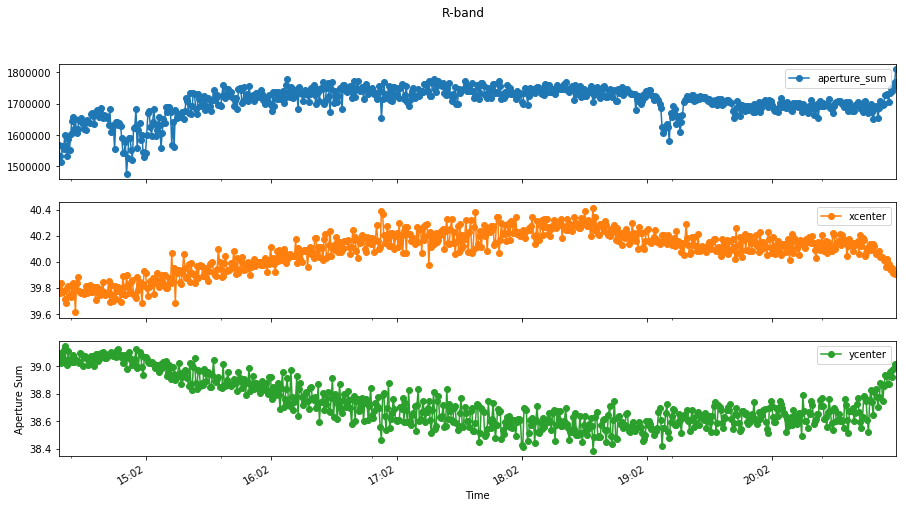

In [16]:
import matplotlib.dates as dates

axs = df_rband.plot(title='R-band', marker='o',subplots=True, figsize=(15,8))
axs.flat[2].xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
axs.flat[2].set_ylabel('Aperture Sum')
axs.flat[2].set_xlabel('Time')

In [17]:
centroid_init = (700, 305)
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []

for i in tqdm(zband):
    hdr = pf.open(i)[0].header
    img = pf.open(i)[0].data

    #get dates from fits header
    date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
    time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
    newdate = time.replace(year=date.year, month=date.month, day=date.day)
    obs_time.append(newdate)
    obs_mjd.append(hdr['MJD-STRT'])

    #crop
    image_crop = get_crop(img, centroid_init, box_size)
    #compute centroid
    centroid = get_centroid(image_crop)
    centroids.append(centroid)
    
    xcenters.append(centroid[0])
    ycenters.append(centroid[1])
    
    #do photometry
    aperture_sum = get_phot(image_crop, centroid)
    aperture_sums.append(aperture_sum)
    
#output as dataframe
d = {'xcenter' : xcenters,
     'ycenter' : ycenters,
     'aperture_sum'    : aperture_sums}

df_zband = pd.DataFrame(d, index = obs_time)

100%|██████████| 377/377 [00:08<00:00, 42.71it/s]


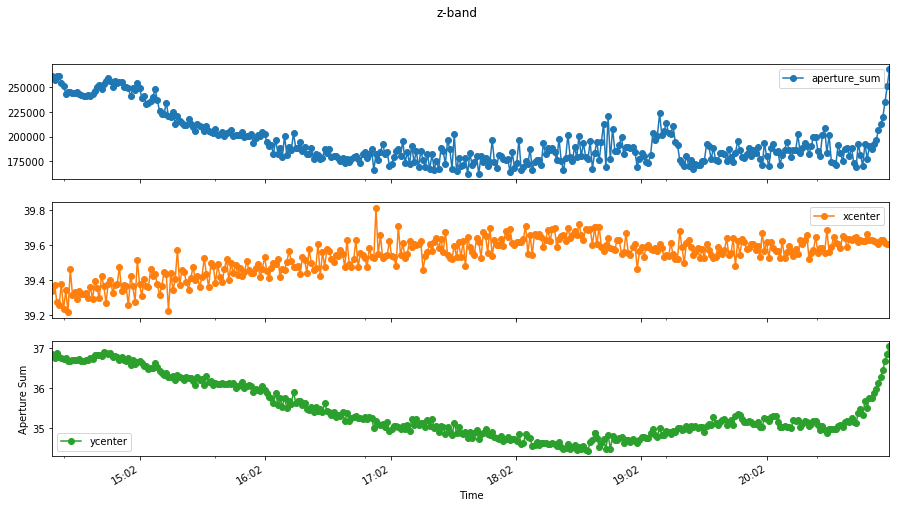

In [18]:
import matplotlib.dates as dates

axs = df_zband.plot(title='z-band', marker='o', subplots=True, figsize=(15,8))
axs.flat[2].xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
axs.flat[2].set_ylabel('Aperture Sum')
axs.flat[2].set_xlabel('Time')

In [19]:
df_rband.columns = ['aperture_sum2', 'xcenter2', 'ycenter2']
df_zband.columns = ['aperture_sum3', 'xcenter3', 'ycenter3']
df_all = df_gband.append([df_rband, df_zband])

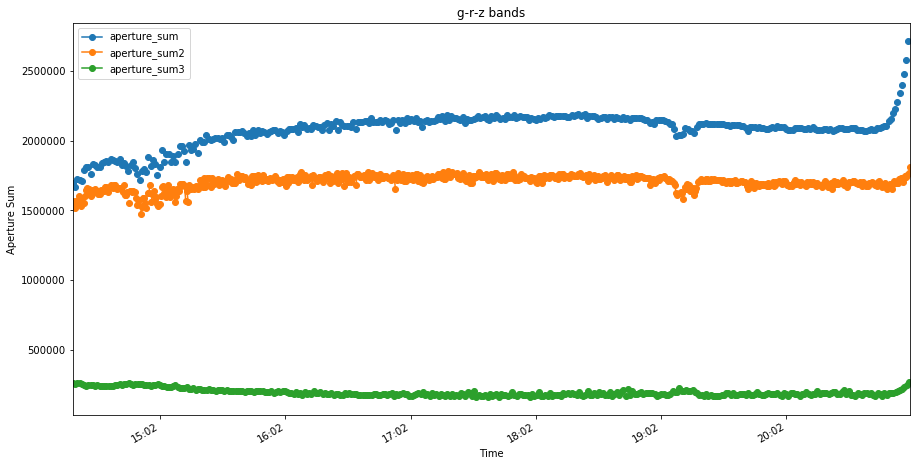

In [20]:
import matplotlib.dates as dates

ax = df_all[['aperture_sum','aperture_sum2','aperture_sum3']].plot(title='g-r-z bands', marker='o', figsize=(15,8))
ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%m'))
ax.set_ylabel('Aperture Sum')
ax.set_xlabel('Time')

In [21]:
df_all.rename(columns={'aperture_sum':'flux_g', 'aperture_sum2':'flux_r', 'aperture_sum3':'flux_z'}, inplace=True)

In [22]:
df_all.head()

,flux_g,flux_r,flux_z,xcenter,xcenter2,xcenter3,ycenter,ycenter2,ycenter3
2017-02-15 14:18:14.529240,1.693393e+06,NaN,NaN,39.855874,NaN,NaN,39.387270,NaN,NaN
2017-02-15 14:19:18.961023,1.670733e+06,NaN,NaN,39.888606,NaN,NaN,39.357057,NaN,NaN
2017-02-15 14:20:23.220731,1.724041e+06,NaN,NaN,39.835488,NaN,NaN,39.424931,NaN,NaN
2017-02-15 14:21:26.308946,1.718451e+06,NaN,NaN,39.816575,NaN,NaN,39.362446,NaN,NaN
2017-02-15 14:22:30.000543,1.712989e+06,NaN,NaN,39.880492,NaN,NaN,39.366442,NaN,NaN


## Saving to csv.gz

In [26]:
df_all.to_csv('hatp44_trial1.csv.gz')

## Manual point retrieval per band (g-r-z) and point source (3)

loop over `idx` and `band` for centroid/point source and g

In [ ]:
box_size = 80

centroids = []
xcenters, ycenters = [],[]
aperture_sums = []
obs_time = []
obs_mjd = []
sum_per_band = {}

bands = [gband,rband,zband]
band_names = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]

def make_d(centroid, band, name):
    
    print "computing photometry for source at centroid {}".format(centroid)
    for i in tqdm(band):
    
        hdr = pf.open(i)[0].header
        img = pf.open(i)[0].data

        #get dates from fits header
        date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
        time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
        newdate = time.replace(year=date.year, month=date.month, day=date.day)
        obs_time.append(newdate)
        obs_mjd.append(hdr['MJD-STRT'])
        
        #try:
        #crop
        image_crop = get_crop(img, centroid, box_size)
        #compute centroid
        centroid = get_centroid(image_crop)
        centroids.append(centroid)

        xcenters.append(centroid[0])
        ycenters.append(centroid[1])

        #do photometry
        aperture_sum = get_phot(image_crop, centroid)
        aperture_sums.append(aperture_sum)
        #except:
            
    #output as dataframe
    d = {'xcenter' : xcenters,
         'ycenter' : ycenters,
         'flux'+str(name)    : aperture_sums}
    return d

dfs = []
for centroid in centroids:
    for band,name in zip(bands, band_names):
        d = make_d(centroid, band, name)
        df = pd.DataFrame(d, index = obs_time)
        dfs.append(df)

In [25]:
#import multiprocessing

box_size = 80

bands = [gband,rband,zband]
band_name = ['g','r','z']
centroids = [(703, 303), (915, 264), (707, 758)]
star_names = 'abc'

band_idx=1
#star_idx=0
dfs = []

##loop in 3 bands
#for star_idx, band in enumerate(bands):

##loop in 3 stars (other star is for flux division later)
for star_idx in range(3):
    xcenters, ycenters = [],[]
    aperture_sums = []
    obs_time = []
    obs_mjd = []
    sum_per_band = {}

    ##extract lightcurve (enumerate all frames) in a given band
    for i in tqdm(bands[band_idx]):
        hdr = pf.open(i)[0].header
        img = pf.open(i)[0].data

        #get dates from fits header
        date=dt.strptime(hdr['DATE-OBS'], '%Y-%m-%d')
        time=dt.strptime(hdr['EXP-STRT'], '%H:%M:%S.%f')
        newdate = time.replace(year=date.year, month=date.month, day=date.day)
        obs_time.append(newdate)
        obs_mjd.append(hdr['MJD-STRT'])

        #crop
        image_crop = get_crop(img, centroids[star_idx], box_size)
        #compute centroid
        centroid = get_centroid(image_crop)
        centroids.append(centroid)

        xcenters.append(centroid[0])
        ycenters.append(centroid[1])

        #do photometry
        aperture_sum = get_phot(image_crop, centroid, r=20)
        aperture_sums.append(aperture_sum)

    #output as dataframe of given band and star 
    d = {'{0}_{1}_x'.format(band_name[band_idx], star_names[star_idx]) : xcenters,
         '{0}_{1}_y'.format(band_name[band_idx], star_names[star_idx]) : ycenters,
         '{0}_{1}_flux'.format(band_name[band_idx], star_names[star_idx]) : aperture_sums}
    dfs.append(pd.DataFrame(d, index = obs_time))

100%|██████████| 704/704 [00:18<00:00, 38.74it/s]


In [26]:
for df in dfs: 
    print(df.shape)

(704, 3)
(704, 3)
(704, 3)


In [27]:
df = pd.concat(dfs, axis=1)
df.head()

,r_a_flux,r_a_x,r_a_y,r_b_flux,r_b_x,r_b_y,r_c_flux,r_c_x,r_c_y
2017-02-15 14:18:12.963052,3.453580e+06,39.501432,39.288093,3.302912e+06,39.439169,39.018641,2.715797e+06,39.766966,39.385470
2017-02-15 14:18:45.888896,3.452255e+06,39.470829,39.244068,3.288069e+06,39.452939,38.974850,2.707337e+06,39.770897,39.372705
2017-02-15 14:19:20.626707,3.445251e+06,39.536454,39.217508,3.286027e+06,39.480402,38.951223,2.698876e+06,39.786212,39.374566
2017-02-15 14:19:55.560678,3.454060e+06,39.472484,39.276124,3.294720e+06,39.446660,39.000530,2.710551e+06,39.773405,39.391422
2017-02-15 14:20:30.195399,3.450802e+06,39.481518,39.311109,3.295708e+06,39.426630,39.024411,2.714576e+06,39.758898,39.399263


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0f96aac6d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x7f0f968b98d0>], dtype=object)

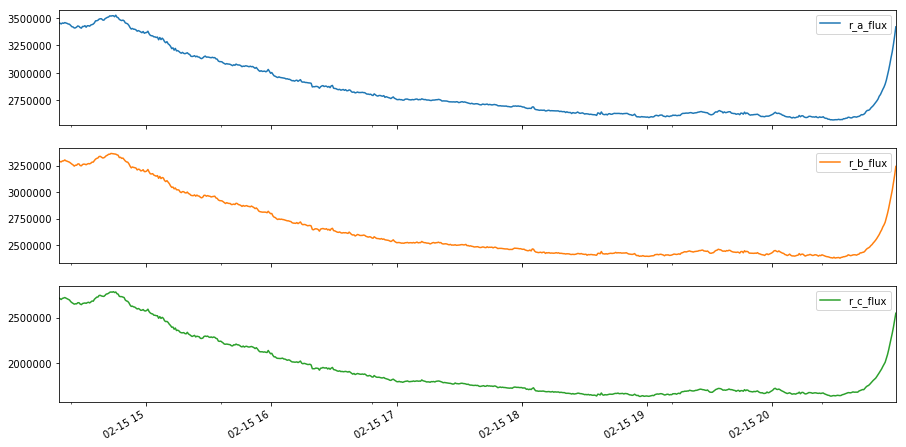

In [28]:
#replace g_ or r_ or z_
cols = 'r_a_flux r_b_flux r_c_flux'.split()
df[cols].plot(subplots=True, figsize=(15,8))

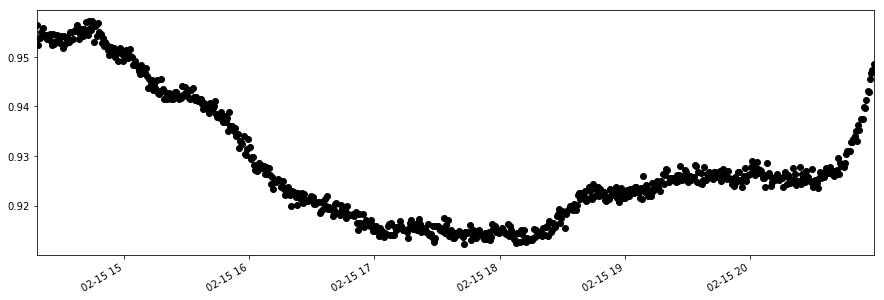

In [29]:
(df['r_b_flux'] / df['r_a_flux']).plot(figsize=(15,5), color='k', marker='o', linestyle='none')

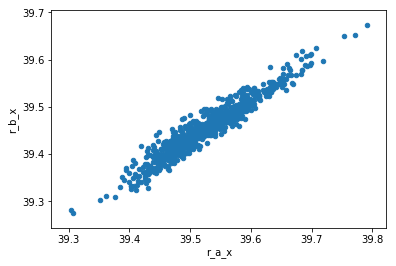

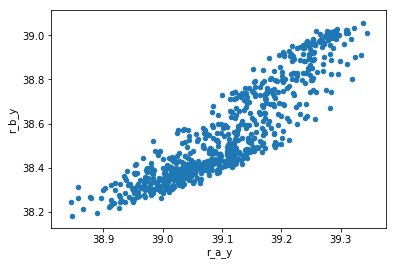

In [30]:
df.plot.scatter(*'r_a_x r_b_x'.split())
df.plot.scatter(*'r_a_y r_b_y'.split())

## Centroid

In [60]:
cols = 'r_a_x r_a_y'.split()
df[cols].plot(subplots=True, figsize=(15,4))

In [37]:
f = (df['r_b_flux'] / df['r_a_flux']).values
f /= np.median(f)

In [38]:
t = df.index.to_julian_date().values

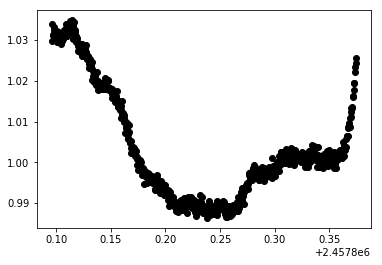

In [39]:
plt.plot(t, f, 'ko')

In [161]:
def scaled_a(p, t14, k, i=np.pi/2, b=0):
    numer = np.sqrt( (k + 1)**2 - b**2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

tc = t.mean()
p = 4.3
k = np.sqrt(0.015)
i = np.pi/2
t14 = 2.8/24
u1 = 0.4
u2 = 0.4
a = scaled_a(p, t14, k, i=np.pi/2, b=b)
# ls = np.log(f.std())
# k0 = 0
# theta = [k,tc,a,i,u1,u2,ls,k0]
theta = [k,tc,a,i,u1,u2]
print "initial guess: {}".format(theta)

initial guess: [0.1224744871391589, 2457800.2350507793, 13.18482235546915, 1.5707963267948966, 0.4, 0.4]


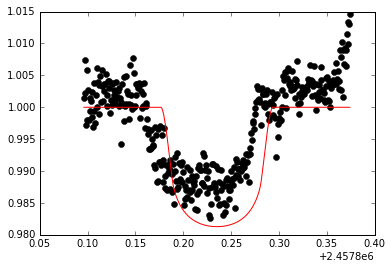

In [162]:
from pytransit import MandelAgol
MA = MandelAgol()

def model_u(theta, t, p):
    k,tc,a,i,u1,u2 = theta
    m = MA.evaluate(t, k, (u1, u2), tc, p, a, i)
    return m

plt.plot(t, f, 'ko', t, model_u(theta, t, p), 'r-')

In [167]:
import scipy.optimize as op

def obj(theta, t, p, f):
    m = model_u(theta, t, p)
    return np.sum((m-f)**2)

print "cost before: {}".format(obj(theta, t, p, f))
res = op.minimize(obj, theta, args=(t, p, f), method='nelder-mead')
print "cost after: {}".format(obj(res.x, t, p, f))

cost before: 0.0134922879783
cost after: 0.00731000239861


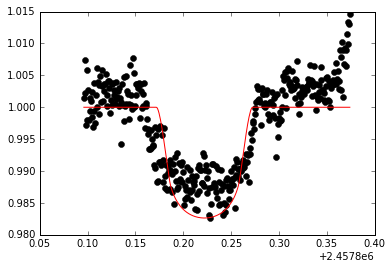

In [169]:
plt.plot(t, f, 'ko', t, model_u(res.x, t, p), 'r-')

In [191]:
ls = np.log(f.std())
k0 = 0
theta = [k,tc,a,i,u1,u2,ls,k0]

def loglike(theta, t, f, p, ret_mod=False):
    ls,k0 = theta[-2:]
    m = model_u(theta[:-2], t, p) + k0
    if ret_mod:
        return m
    resid = f - m
    inv_sig2 = np.exp(-2*ls)
    return -0.5*(np.sum((resid)**2 * inv_sig2 + 2*ls))

nll = lambda *x: -loglike(*x)

print "NLL before: {}".format(nll(theta, t, f, p))
res = op.minimize(nll, theta, args=(t, p, f), method='powell')
print "NLL after: {}".format(nll(res.x, t, f, p))

NLL before: -1727.47602958
NLL after: 1.46402191976e+28


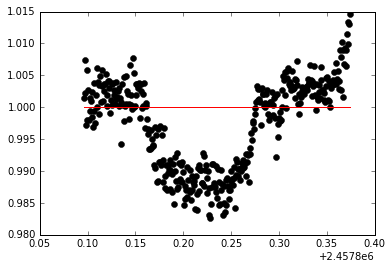

In [193]:
plt.plot(t, f, 'ko', t, model_u(res.x[:-2], t, p), 'r-')

In [220]:
def logprob(theta, t, f, p, up=None, ret_mod=False):

    if ret_mod:
        return loglike(theta, t, f, p, ret_mod=True)

    k,tc,a,i,u1,u2,ls,k0 = theta

    if u1 < 0 or u1 > 2 or u2 < -1 or u2 > 1 or k < 0 or k > 1 or i > np.pi/2:
        return -np.inf

    lp = 0
    if up is not None:
        lp += np.log(stats.norm.pdf(u1, loc=up[0], scale=up[1]))
        lp += np.log(stats.norm.pdf(u2, loc=up[2], scale=up[3]))

    ll = loglike(theta, t, f, p)

    if np.isnan(ll).any():
        return -np.inf
    return lp + ll


nlp = lambda *x: -logprob(*x)

print "NLP before: {}".format(nlp(theta, t, f, p))
res = op.minimize(nlp, theta, args=(t, p, f), method='nelder-mead')
print "NLP after: {}".format(nlp(res.x, t, f, p))

NLP before: -1727.47602958
NLP after: 443.933179157


In [195]:
zip(theta, res.x)

[(0.1224744871391589, 0.00037172196662623195),
 (2457800.2350507793, 1974550.3418047049),
 (13.18482235546915, -18.223712254367154),
 (1.5707963267948966, 3.2604124872359739),
 (0.4, 1.2767952587087914),
 (0.4, -0.95980560466028753),
 (-4.9569299324884097, 1.1806554940703813),
 (0, 0.015493959673583298)]

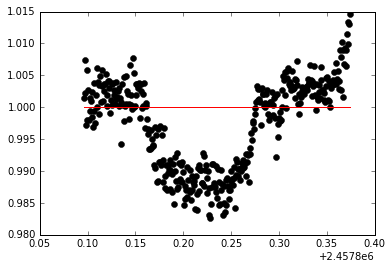

In [196]:
plt.plot(t, f, 'ko', t, model_u(res.x[:-2], t, p), 'r-')

In [198]:
from emcee import MHSampler, EnsembleSampler
from emcee.utils import sample_ball

ndim = len(theta)
nwalkers = 8 * ndim if ndim > 12 else 16 * ndim
nsteps1 = 1000

args = t, f, p
sampler = EnsembleSampler(nwalkers, ndim, logprob,
    args=args, threads=1)
pos0 = sample_ball(theta, [1e-4]*ndim, nwalkers)

for pos,_,_ in tqdm(sampler.sample(pos0, iterations=nsteps1)):
    pass

1000it [00:07, 131.79it/s]


In [201]:
for i,j in zip(theta, sampler.flatchain.mean(axis=0)): print i,j


0.122474487139 0.108545625432
2457800.23505 2457800.21956
13.1848223555 11.8745087136
1.57079632679 1.56739393561
0.4 0.509622565953
0.4 0.293195032246
-4.95692993249 -5.75793165437
0 0.0024665273432


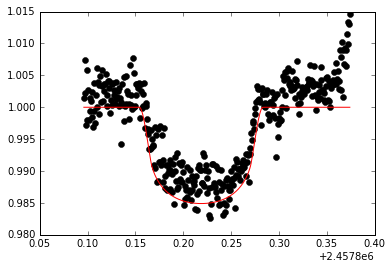

In [203]:
theta_new = np.median(sampler.flatchain, axis=0)

plt.plot(t, f, 'ko', t, model_u(theta_new[:-2], t, p), 'r-')

In [207]:
sampler.reset()
for pos,_,_ in tqdm(sampler.sample(pos, iterations=nsteps1*5)):
    pass

5000it [00:36, 136.97it/s]


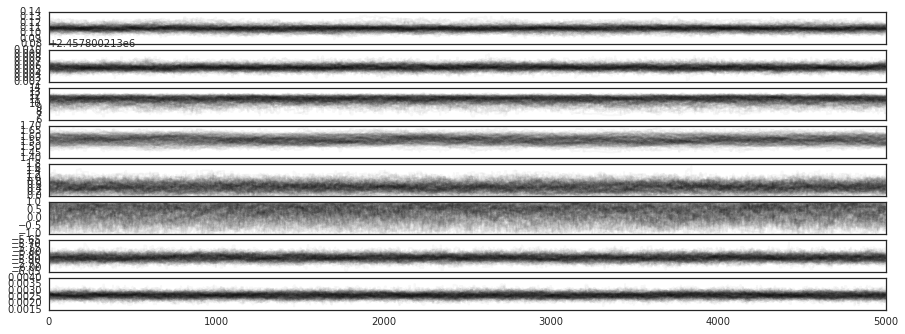

In [208]:
chain = sampler.chain
import seaborn as sb
with sb.axes_style('white'):
    nwalkers, nsteps, ndim = chain.shape
    fig, axs = plt.subplots(ndim, 1, figsize=(15,ndim/1.5), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]

In [221]:
ps = [logprob(th, t, f, p, ret_mod=True) for th in sampler.flatchain[np.random.randint(0, sampler.flatchain.shape[0], size=100)]]


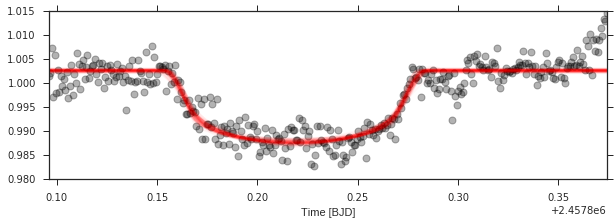

In [226]:
with sb.axes_style('ticks'):
    fig, ax = plt.subplots(1, 1, figsize=(10,3))
    ax.plot(t, f, linestyle='none', marker='o',
        color='k', alpha=0.3, mew=1, mec='k')
    for s in ps:
        ax.plot(t, s, 'r-', alpha=0.03)
    plt.setp(ax, xlabel='Time [BJD]',
        xlim=(t.min(), t.max()))

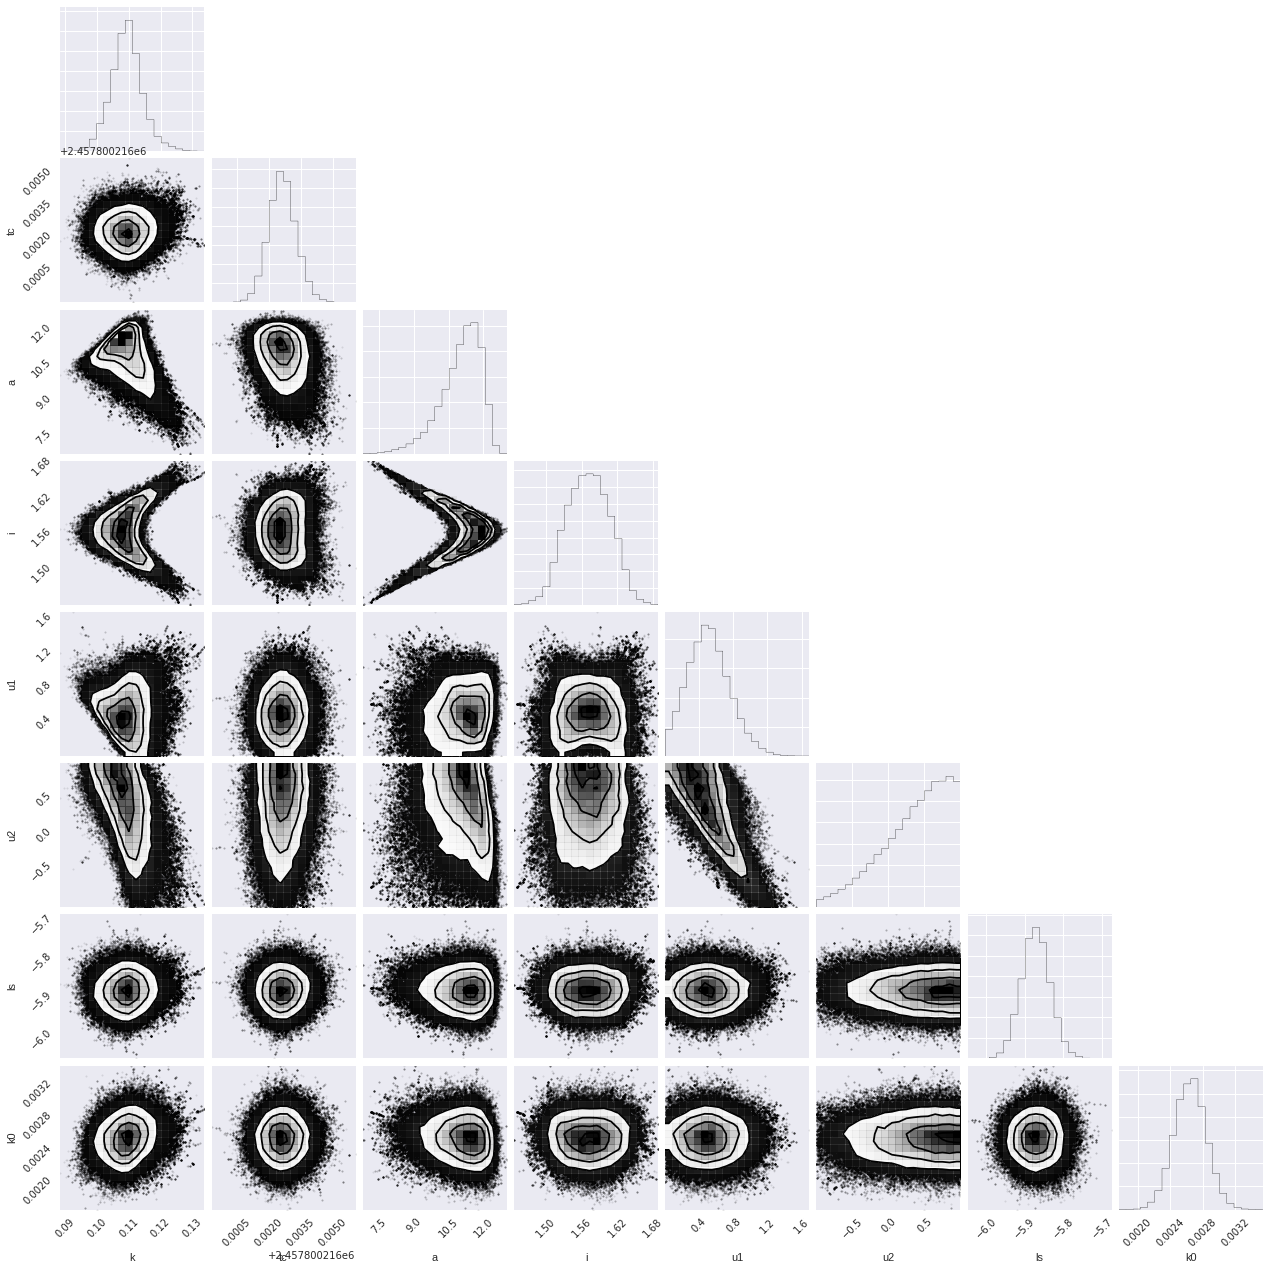

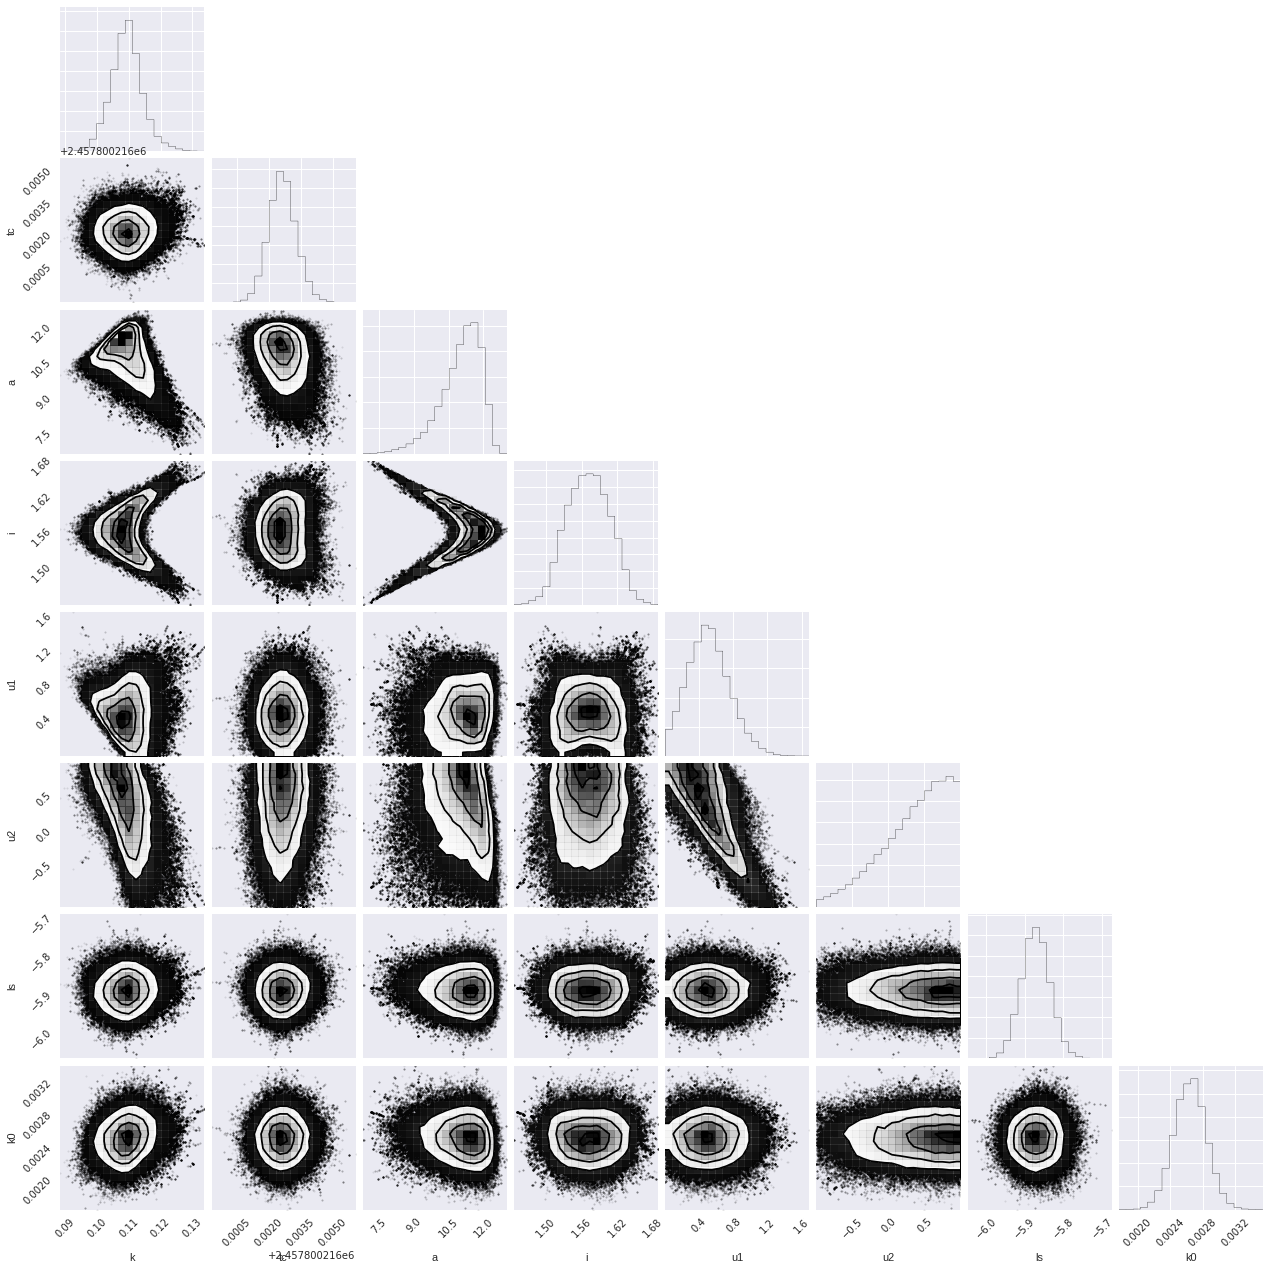

In [227]:
import corner
corner.corner(sampler.flatchain, labels='k,tc,a,i,u1,u2,ls,k0'.split(','));

In [ ]:
from pandas.tools.plotting import scatter_matrix

def plot_matrix(df):
    scatter_matrix(df, figsize=(15,15), marker='o', alpha=0.5);
    plt.show()

plot_matrix(df_g)